In [1]:
import __init__

import glob
import os
import warnings
import numpy as np;
 
import skimage.io as io
from skimage import morphology
from skimage import feature
from skimage import measure
from skimage import segmentation
from skimage.transform import resize
from skimage import filters
from skimage import img_as_ubyte

import cfg
import imtools
import diagnostics
import segmentations
import cell_morphology
import annotations

%matplotlib inline 

Setting parameters

In [2]:
param=cfg.param() 
output_dir=param.getOutDir('output')
diag_dir=param.getOutDir('diag')
vis_diag=False

Selecting an image file to process

In [3]:
imDirs=os.listdir(param.getImageDirs())
print(imDirs)
image_dir=param.getImageDirs(dir_name=imDirs[-1])
included_extenstions = ['*.jpg', '*.bmp', '*.png', '*.gif']
image_list_indir = []
for ext in included_extenstions:
   image_list_indir.extend(glob.glob(os.path.join(image_dir, ext)))

for i, image_file in enumerate(image_list_indir):
    print(str(i)+' : '+image_file)

['Basophil', 'Lymphocyte', 'Neutrophil', 'Problem']
0 : .\data\Test\WBC Types\Problem\99_EO.jpg
1 : .\data\Test\WBC Types\Problem\100_K32.bmp
2 : .\data\Test\WBC Types\Problem\103_K32.bmp
3 : .\data\Test\WBC Types\Problem\105_K32.bmp
4 : .\data\Test\WBC Types\Problem\11_17_gepi_5_8_13.bmp
5 : .\data\Test\WBC Types\Problem\11_K32.bmp
6 : .\data\Test\WBC Types\Problem\13_LY.bmp
7 : .\data\Test\WBC Types\Problem\14_17_gepi_5_8_13.bmp
8 : .\data\Test\WBC Types\Problem\159_K32.bmp
9 : .\data\Test\WBC Types\Problem\17_LY.bmp
10 : .\data\Test\WBC Types\Problem\208_K32.bmp
11 : .\data\Test\WBC Types\Problem\36_NE.bmp
12 : .\data\Test\WBC Types\Problem\45_MO.bmp
13 : .\data\Test\WBC Types\Problem\47_NE.bmp
14 : .\data\Test\WBC Types\Problem\49_NE.bmp
15 : .\data\Test\WBC Types\Problem\52_NE.bmp
16 : .\data\Test\WBC Types\Problem\80_LY.bmp
17 : .\data\Test\WBC Types\Problem\8_NE.bmp
18 : .\data\Test\WBC Types\Problem\96_EO.bmp
19 : .\data\Test\WBC Types\Problem\MGcsv9916_10123_4226_200.bmp


In [4]:
image_file=image_list_indir[0]
print(image_file)

.\data\Test\WBC Types\Problem\99_EO.jpg


In [5]:
im = io.imread(image_file) # read uint8 image

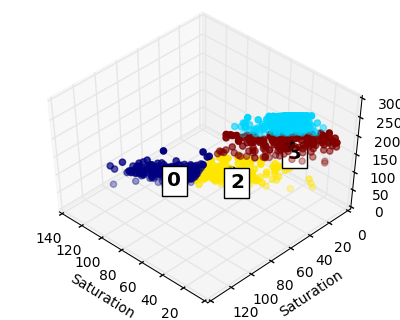

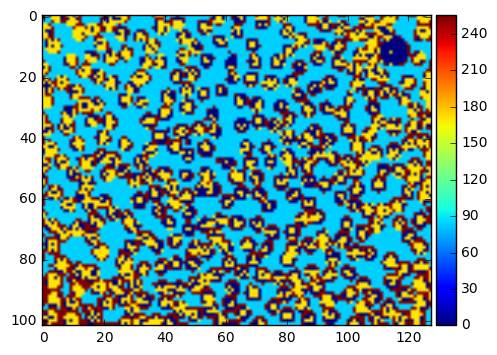

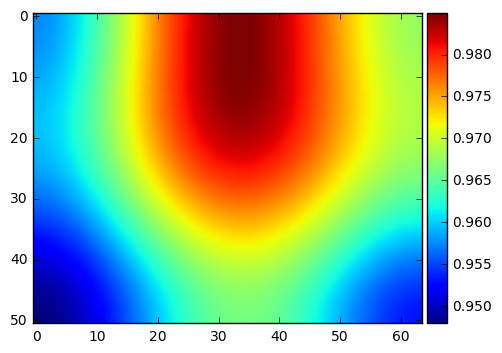

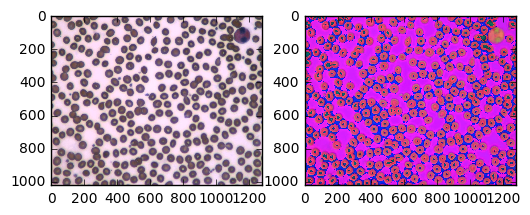

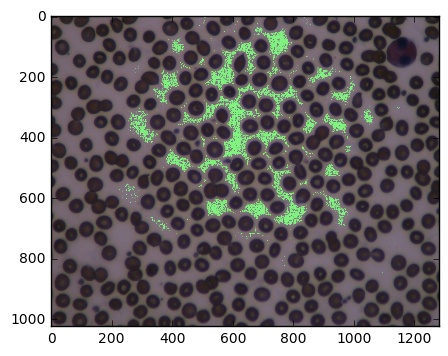

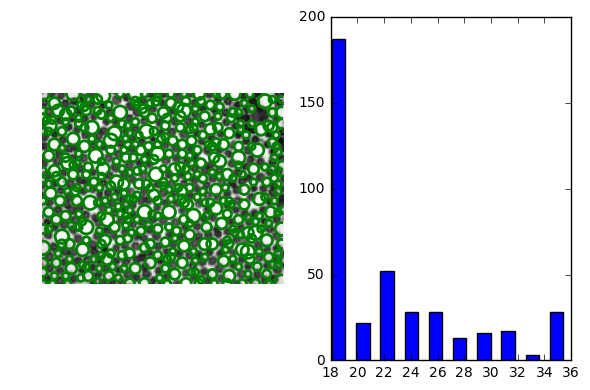

Error list:
ch_maxvar :0
saturation_q90 :87


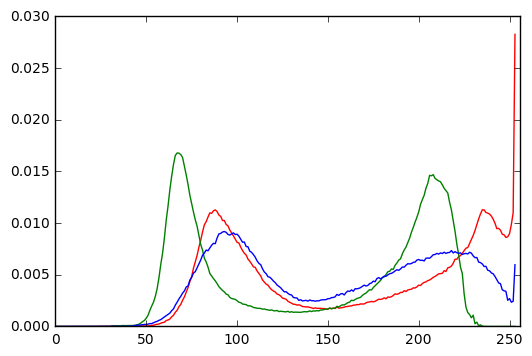

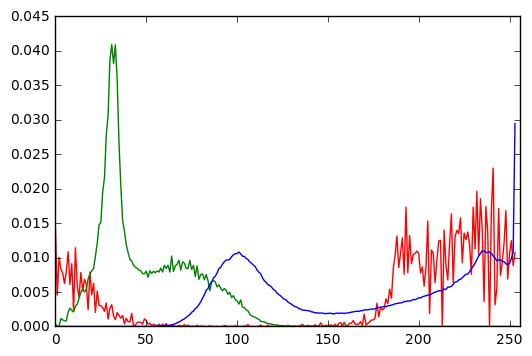

In [6]:
diag=diagnostics.diagnostics(im,image_file,vis_diag=True)


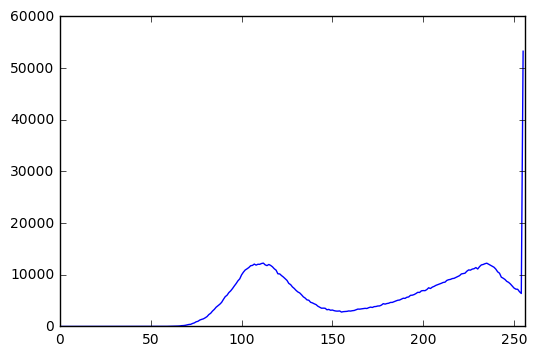

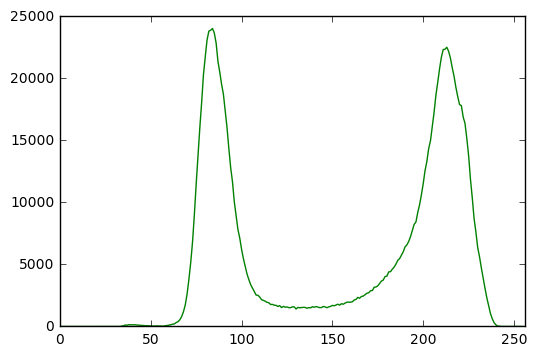

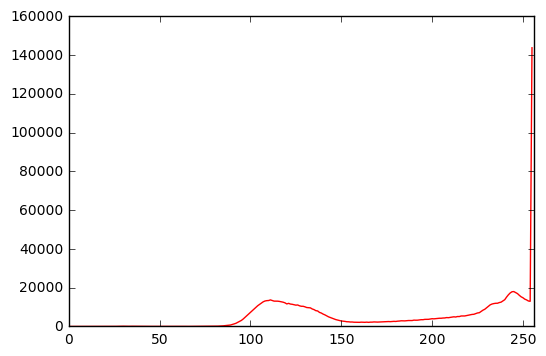

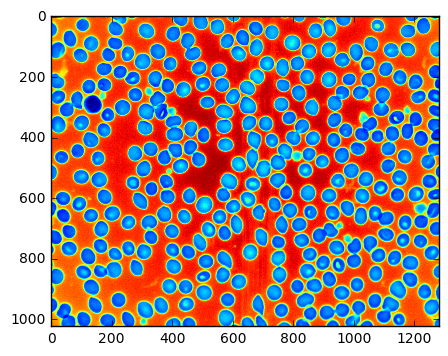

In [3]:
hist = tools.colorHist(im,1)
im_onech = im[:,:,1];
plt.imshow(im_onech)

In [4]:
th, foreground_mask = cv2.threshold(im_onech,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# processing for dtf

r=int(param.rbcR/2)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(r,r))

foreground_mask_open=cv2.morphologyEx(foreground_mask, cv2.MORPH_OPEN, kernel, iterations=1)

# filling convex holes

background_mask=255-foreground_mask_open

output = cv2.connectedComponentsWithStats(background_mask, 8, cv2.CV_32S)


for i in range(output[0]):
    area=output[2][i][4]
    if area<param.rbcR*param.rbcR/5: 
        foreground_mask_open[output[1]==i]=255


# use dtf to find markers for watershed
dist_transform = cv2.distanceTransform(foreground_mask_open,cv2.DIST_L2,5)

dist_transform[dist_transform<param.rbcR*0.5]=0

# watershed
r=int(param.rbcR/2)
kernel = np.ones((r,r),np.uint8)

local_maxi = feature.peak_local_max(dist_transform, indices=False, footprint=np.ones((int(param.rbcR*0.6), int(param.rbcR*0.6))), labels=foreground_mask_open)
local_maxi_dilate=cv2.dilate(local_maxi.astype('uint8')*255,kernel, iterations = 1)
markers = measure.label(local_maxi_dilate)


# watershed on dtf
labels_ws = morphology.watershed(-dist_transform, markers, mask=foreground_mask_open)

# edge map for visualization
mag = tools.getGradientMagnitude(labels_ws.astype('float32'))
mag[mag>0]=255

im2=tools.maskOverlay(im,mag,0.5,1,0)
cv2.namedWindow('detected')
# counting

for label in np.unique(labels_ws):
        # if the label is zero, we are examining the 'background'
        # so simply ignore it
     if label == 0:
         continue

     mask = np.zeros(im_onech.shape, dtype="uint8")
     mask[labels_ws == label] = 255
     cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2]
     c = max(cnts, key=cv2.contourArea)
     x,y,w,h = cv2.boundingRect(c)
     if ((x>param.rbcR) & (x+w<im.shape[1]-param.rbcR) & 
         (y>param.rbcR) & (y+h<im.shape[0]-param.rbcR)):
        cv2.rectangle(im2,(x,y),(x+w,y+h),(255,255,255),2)
        cv2.putText(im2, "#{}".format(label), (x - 10, y),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2) 
        if cv2.contourArea(c)>2*int(math.pi*math.pow(param.wbcRatio*param.rbcR,2)):
            cv2.rectangle(im2,(x,y),(x+w,y+h),(0,0,255),3)
cv2.imshow('detected',im2)    
cv2.waitKey()

-1